In [1]:
import os

from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
tf.__version__

'2.3.0'

In [3]:
image_paths = list()
for filename in os.listdir('../data'):
    image_path = os.path.join('../data', filename)
    if os.path.isfile(image_path):
        image_paths.append(image_path)
len(image_paths)

1070

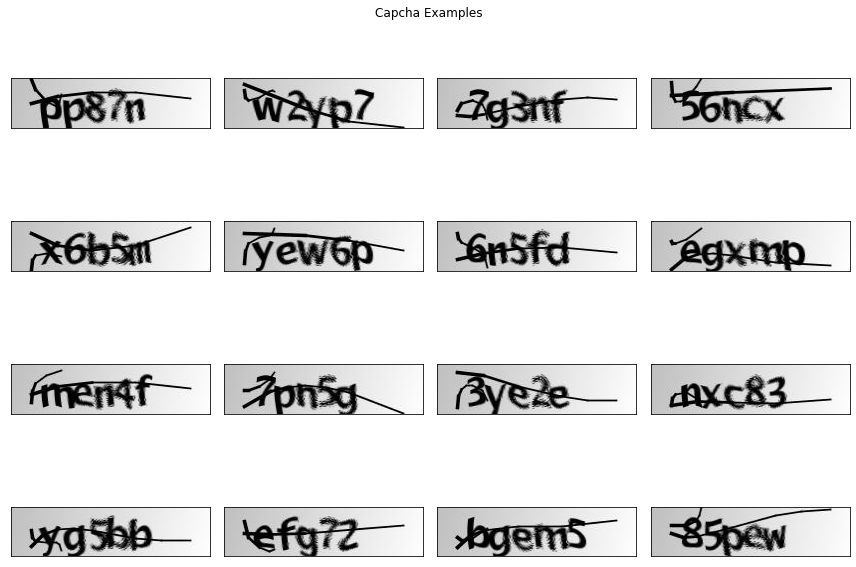

In [4]:
N = len(image_paths)
nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 9))

number = np.random.choice(N, size=nrows * ncols, replace=False)

for idx, number in enumerate(number):
    r = idx // nrows
    c = idx % ncols

    image = tf.io.read_file(image_paths[number])
    image = tf.io.decode_image(image)[:, :, :3]

    ax[r][c].imshow(image)
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([])

fig.tight_layout()
fig.suptitle('Capcha Examples')
fig.show()

In [5]:
class GANNetwork:
    def __init__(self):
        self.image_shape = (50, 200, 3)
        self.noise_shape = (100, )

        self.optimizer = Adam()

        self.generator = self.build_generator()
        self.generator.compile(optimizer=self.optimizer, loss='binary_crossentropy')
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        noise = keras.Input(self.noise_shape)
        generated_image = self.generator(noise)
        self.discriminator.trainable = False
        validity = self.discriminator(generated_image)
        self.combined = keras.Model(noise, validity)
        self.combined.compile(optimizer=self.optimizer, loss='binary_crossentropy')

    def build_generator(self):
        model = keras.models.Sequential()

        model.add(Dense(256, input_shape=self.noise_shape))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(512))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
        
        model.add(Dense(1024))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(np.product(self.image_shape), activation='tanh'))
        model.add(Reshape(self.image_shape))

        noise = keras.Input(self.noise_shape)
        image = model(noise)
        return keras.Model(noise, image)

    def build_discriminator(self):
        model = keras.models.Sequential()
        model.add(Flatten(input_shape=self.image_shape))

        model.add(Dense(512))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(256))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(1, activation='sigmoid'))

        image = keras.Input(self.image_shape)
        validity = model(image)

        return keras.Model(image, validity)

    def train(self, epochs, batch_size, save_interval):
        dataset = load_images(image_paths)
        dataset = dataset.astype(np.float32) / 255.0
        half_batch_size = batch_size // 2
        for epoch in range(epochs):

            indices = np.random.randint(0, dataset.shape[0], (half_batch_size))
            images = dataset[indices]

            noise = np.random.normal(0, 1, (half_batch_size, self.noise_shape[0]))
            generated_images = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(images, np.ones((half_batch_size, 1)))
            d_loss_fake = self.discriminator.train_on_batch(generated_images, np.zeros((half_batch_size, 1)))

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.noise_shape[0]))
            validity = np.ones((batch_size, 1))
            g_loss = self.combined.train_on_batch(noise, validity)
            
            print(
                f'{epoch:8}\t',
                f'[D loss: {d_loss[0]:.4f}, acc: {d_loss[1]:.2%}]\t',
                f'[G loss: {g_loss:.4f}]'
            )
            if epoch % save_interval == 0:
                self.save_images(epoch)    

    def save_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :3])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig('images/capcha_{}.png'.format(epoch))
        plt.close()


In [6]:
def load_images(image_paths):
    dataset = np.zeros(shape=(len(image_paths), 50, 200, 3))
    for idx, path in tqdm(enumerate(image_paths)):
        image = tf.io.read_file(path)
        image = tf.io.decode_image(image)[:, :, :3]
        dataset[idx] = image
    print(f'{dataset.shape}')
    return dataset

In [7]:
network = GANNetwork()
network.train(epochs=30000, batch_size=32, save_interval=50)

[D loss: 0.6939, acc: 50.00%]	 [G loss: 0.5860]
    1031	 [D loss: 0.6938, acc: 46.88%]	 [G loss: 0.5920]
    1032	 [D loss: 0.6941, acc: 34.38%]	 [G loss: 0.5988]
    1033	 [D loss: 0.6939, acc: 46.88%]	 [G loss: 0.6136]
    1034	 [D loss: 0.6936, acc: 62.50%]	 [G loss: 0.6278]
    1035	 [D loss: 0.6943, acc: 43.75%]	 [G loss: 0.6272]
    1036	 [D loss: 0.6941, acc: 43.75%]	 [G loss: 0.6220]
    1037	 [D loss: 0.6937, acc: 56.25%]	 [G loss: 0.6194]
    1038	 [D loss: 0.6950, acc: 59.38%]	 [G loss: 0.6256]
    1039	 [D loss: 0.6939, acc: 53.12%]	 [G loss: 0.6423]
    1040	 [D loss: 0.6941, acc: 65.62%]	 [G loss: 0.6608]
    1041	 [D loss: 0.6938, acc: 50.00%]	 [G loss: 0.6453]
    1042	 [D loss: 0.6938, acc: 56.25%]	 [G loss: 0.6133]
    1043	 [D loss: 0.6938, acc: 46.88%]	 [G loss: 0.5994]
    1044	 [D loss: 0.6935, acc: 46.88%]	 [G loss: 0.5973]
    1045	 [D loss: 0.6935, acc: 40.62%]	 [G loss: 0.5856]
    1046	 [D loss: 0.6938, acc: 40.62%]	 [G loss: 0.5947]
    1047	 [D loss: 0.693

KeyboardInterrupt: 